# Linear Regression with Feature Engineering

**Objective:** Apply Linear Regression to the cleaned and engineered data to evaluate if preprocessing improves model performance.

**Hypothesis:** Better data quality through feature engineering should improve Linear Regression performance compared to raw data baseline.

**Raw Data Baseline (from previous notebook):**
- R² = 15.19%
- MAE = $607.72
- MAPE = 261.54%

**Your Feature Engineering Steps:**
1.  Handled missing values strategically
2.  Dropped rows with missing Age, Vehicle Age, Insurance Duration
3.  Filled Number of Dependents & Previous Claims with 0
4.  Filled categorical columns (Occupation, Customer Feedback, Marital Status) with 'Unknown'
5.  Filled numeric columns (Credit Score, Health Score, Annual Income) with median

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import gc
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 1. Load and Apply Feature Engineering

In [28]:
# File paths
TRAIN_PATH = "../data/train.csv"
TEST_PATH = "../data/test.csv"
TARGET_COL = "Premium Amount"

print("Loading data...")
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

print(f"Original Training set: {df_train.shape}")
print(f"Original Test set: {df_test.shape}")

Loading data...
Original Training set: (1200000, 21)
Original Test set: (800000, 20)


### Apply Feature Engineering to Training Data

In [29]:
print("\n" + "="*70)
print("APPLYING FEATURE ENGINEERING TO TRAINING DATA")
print("="*70)

# 1. Replace invalid values with NaN
print("\n1. Cleaning Age, Vehicle Age, Insurance Duration...")
df_train['Age'] = df_train['Age'].replace(['', 'NaN', 'unknown'], pd.NA)
df_train['Vehicle Age'] = df_train['Vehicle Age'].replace(['', 'NaN', 'unknown'], pd.NA)
df_train['Insurance Duration'] = df_train['Insurance Duration'].replace(['', 'NaN', 'unknown'], pd.NA)

# 2. Drop rows with missing critical fields
print("2. Dropping rows with missing Age, Vehicle Age, Insurance Duration...")
original_size = len(df_train)
df_train = df_train.dropna(subset=['Age']).reset_index(drop=True)
df_train = df_train.dropna(subset=['Vehicle Age']).reset_index(drop=True)
df_train = df_train.dropna(subset=['Insurance Duration']).reset_index(drop=True)
print(f"   Dropped {original_size - len(df_train):,} rows → New size: {len(df_train):,}")

# 3. Fill Number of Dependents and Previous Claims with 0
print("3. Filling Number of Dependents & Previous Claims with 0...")
df_train['Number of Dependents'] = df_train['Number of Dependents'].fillna(0)
df_train['Previous Claims'] = df_train['Previous Claims'].fillna(0)

# 4. Fill categorical columns with 'Unknown'
print("4. Filling categorical columns (Occupation, Customer Feedback, Marital Status) with 'Unknown'...")
cat_fill_unknown = ['Occupation', 'Customer Feedback', 'Marital Status']
for col in cat_fill_unknown:
    df_train[col] = df_train[col].fillna('Unknown')

# 5. Fill numeric columns with median
print("5. Filling numeric columns (Credit Score, Health Score, Annual Income) with median...")
df_train['Credit Score'] = df_train['Credit Score'].fillna(df_train['Credit Score'].median())
df_train['Health Score'] = df_train['Health Score'].fillna(df_train['Health Score'].median())
df_train['Annual Income'] = df_train['Annual Income'].fillna(df_train['Annual Income'].median())

# Check for remaining missing values
missing_count = df_train.isnull().sum().sum()
print(f"\n✓ Feature engineering complete!")
print(f"✓ Remaining missing values: {missing_count}")
print(f"✓ Final training size: {len(df_train):,} samples")
print("="*70)


APPLYING FEATURE ENGINEERING TO TRAINING DATA

1. Cleaning Age, Vehicle Age, Insurance Duration...
2. Dropping rows with missing Age, Vehicle Age, Insurance Duration...
   Dropped 18,712 rows → New size: 1,181,288
3. Filling Number of Dependents & Previous Claims with 0...
4. Filling categorical columns (Occupation, Customer Feedback, Marital Status) with 'Unknown'...
5. Filling numeric columns (Credit Score, Health Score, Annual Income) with median...

✓ Feature engineering complete!
✓ Remaining missing values: 0
✓ Final training size: 1,181,288 samples


### Apply Same Engineering to Test Data

In [30]:
print("\n" + "="*70)
print("APPLYING FEATURE ENGINEERING TO TEST DATA")
print("="*70)

# Apply same transformations to test data
df_test['Age'] = df_test['Age'].replace(['', 'NaN', 'unknown'], pd.NA)
df_test['Vehicle Age'] = df_test['Vehicle Age'].replace(['', 'NaN', 'unknown'], pd.NA)
df_test['Insurance Duration'] = df_test['Insurance Duration'].replace(['', 'NaN', 'unknown'], pd.NA)

# For test data, we fill missing Age/Vehicle Age/Insurance Duration instead of dropping
# (we need to predict for all test samples)
df_test['Age'] = df_test['Age'].fillna(df_train['Age'].median())
df_test['Vehicle Age'] = df_test['Vehicle Age'].fillna(df_train['Vehicle Age'].median())
df_test['Insurance Duration'] = df_test['Insurance Duration'].fillna(df_train['Insurance Duration'].median())

df_test['Number of Dependents'] = df_test['Number of Dependents'].fillna(0)
df_test['Previous Claims'] = df_test['Previous Claims'].fillna(0)

for col in cat_fill_unknown:
    df_test[col] = df_test[col].fillna('Unknown')

df_test['Credit Score'] = df_test['Credit Score'].fillna(df_train['Credit Score'].median())
df_test['Health Score'] = df_test['Health Score'].fillna(df_train['Health Score'].median())
df_test['Annual Income'] = df_test['Annual Income'].fillna(df_train['Annual Income'].median())

print(f"✓ Test data cleaned: {df_test.shape}")
print("="*70)


APPLYING FEATURE ENGINEERING TO TEST DATA
✓ Test data cleaned: (800000, 20)


## 2. Prepare Features and Target

In [31]:
# Separate features and target
X_train = df_train.drop(columns=[TARGET_COL])
y_train = df_train[TARGET_COL]
X_test = df_test.copy()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Identify feature types
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric features ({len(numeric_cols)}): {numeric_cols}")
print(f"Categorical features ({len(categorical_cols)}): {categorical_cols}")

# Free memory
del df_train, df_test
gc.collect()

X_train shape: (1181288, 20)
y_train shape: (1181288,)
X_test shape: (800000, 20)

Numeric features (9): ['id', 'Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration']
Categorical features (11): ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Policy Start Date', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']


24247

## 3. Build Preprocessing Pipeline

**Note:** Unlike the raw data baseline, we don't need SimpleImputer since you've already handled all missing values!

In [32]:
# Preprocessing for numeric features (StandardScaler for Linear Regression)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True, dtype=np.float32))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    n_jobs=-1
)

# Create full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression(n_jobs=-1))
])

print("✓ Linear Regression pipeline created (with cleaned data)")
print("\nPipeline structure:")
print(pipeline)

✓ Linear Regression pipeline created (with cleaned data)

Pipeline structure:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['id', 'Age', 'Annual Income',
                                                   'Number of Dependents',
                                                   'Health Score',
                                                   'Previous Claims',
                                                   'Vehicle Age',
                                                   'Credit Score',
                                                   'Insurance Duration']),
                                                 ('cat',
                                                  Pipeline(step

## 4. Train the Model

In [33]:
print("\n" + "="*70)
print("TRAINING LINEAR REGRESSION ON CLEANED DATA")
print("="*70)
print("This may take a few minutes...\n")

# Train the model
pipeline.fit(X_train, y_train)

print("✓ Training complete!")
print("="*70)

# Free memory
gc.collect()


TRAINING LINEAR REGRESSION ON CLEANED DATA
This may take a few minutes...

✓ Training complete!


27

## 5. Evaluate on Training Data

In [34]:
print("Generating predictions on training data...")
y_train_pred = pipeline.predict(X_train)

# Convert to numpy arrays
y_train_arr = np.asarray(y_train, dtype=np.float64).ravel()
y_train_pred = np.asarray(y_train_pred, dtype=np.float64).ravel()

# Calculate metrics
mae = mean_absolute_error(y_train_arr, y_train_pred)
rmse = np.sqrt(mean_squared_error(y_train_arr, y_train_pred))
r2 = r2_score(y_train_arr, y_train_pred)

# MAPE (avoid divide-by-zero)
mask = (y_train_arr != 0)
if mask.sum() > 0:
    mape = np.mean(np.abs((y_train_arr[mask] - y_train_pred[mask]) / y_train_arr[mask])) * 100
else:
    mape = float('nan')

explained_var = explained_variance_score(y_train_arr, y_train_pred)

# Display results
print("\n" + "="*75)
print(" LINEAR REGRESSION (WITH FEATURE ENGINEERING) ".center(75, "="))
print("="*75)
print(f"\n R² Score: {r2*100:.2f}%")
print(f"   ➜ Model explains {r2*100:.2f}% of the variance in premium amounts")
print(f"\n Explained Variance Score: {explained_var*100:.2f}%")
print(f"\n Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"   ➜ Average prediction error is ${mae:,.2f}")
print(f"\n Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"   ➜ Typical prediction deviation is ${rmse:,.2f}")

if not np.isnan(mape):
    print(f"\n💰 Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"   ➜ Average error is {mape:.2f}% of actual premium amounts")
else:
    print(f"\n💰 Mean Absolute Percentage Error (MAPE): N/A")
    
print("="*75)

if r2 >= 0.9:
    print("\n EXCELLENT Model Performance!")
elif r2 >= 0.7:
    print("\n GOOD Model Performance!")
elif r2 >= 0.5:
    print("\n  MODERATE Model Performance")
else:
    print("\n POOR Model Performance")
print("="*75)

Generating predictions on training data...

=============== LINEAR REGRESSION (WITH FEATURE ENGINEERING) ==============

 R² Score: 15.42%
   ➜ Model explains 15.42% of the variance in premium amounts

 Explained Variance Score: 15.42%

 Mean Absolute Error (MAE): $606.77
   ➜ Average prediction error is $606.77

 Root Mean Squared Error (RMSE): $795.54
   ➜ Typical prediction deviation is $795.54

💰 Mean Absolute Percentage Error (MAPE): 261.10%
   ➜ Average error is 261.10% of actual premium amounts

 POOR Model Performance


## 6. Compare with Raw Data Baseline

In [35]:
# Baseline metrics (from raw data notebook)
baseline_r2 = 15.19
baseline_mae = 607.72
baseline_mape = 261.54

# Calculate improvements
r2_improvement = ((r2 * 100) - baseline_r2)
mae_improvement = ((baseline_mae - mae) / baseline_mae * 100)
mape_improvement = ((baseline_mape - mape) / baseline_mape * 100) if not np.isnan(mape) else 0

print("\n" + "="*75)
print(" IMPACT OF FEATURE ENGINEERING ".center(75, "="))
print("="*75)
print(f"\n{'Metric':<30} {'Raw Data':<20} {'Cleaned Data':<20} {'Change':<15}")
print("-"*75)
print(f"{'R² Score':<30} {baseline_r2:>18.2f}% {r2*100:>18.2f}% {r2_improvement:>+13.2f}pp")
print(f"{'MAE':<30} ${baseline_mae:>17,.2f} ${mae:>17,.2f} {mae_improvement:>13.1f}%")
if not np.isnan(mape):
    print(f"{'MAPE':<30} {baseline_mape:>18.2f}% {mape:>18.2f}% {mape_improvement:>13.1f}%")
print("="*75)

# Interpretation
if r2_improvement > 5:
    print(f"\n🎉 Feature engineering improved R² by {r2_improvement:.2f} percentage points!")
elif r2_improvement > 0:
    print(f"\n✓ Small improvement of {r2_improvement:.2f}pp in R²")
else:
    print(f"\n⚠️  R² decreased by {abs(r2_improvement):.2f}pp - feature engineering didn't help Linear Regression")
    print("   → Linear Regression still fundamentally inadequate for this problem")
    print("   → Non-linear models (Random Forest, XGBoost) still needed")


====================== IMPACT OF FEATURE ENGINEERING ======================

Metric                         Raw Data             Cleaned Data         Change         
---------------------------------------------------------------------------
R² Score                                    15.19%              15.42%         +0.23pp
MAE                            $           607.72 $           606.77           0.2%
MAPE                                       261.54%             261.10%           0.2%

✓ Small improvement of 0.23pp in R²


## 7. Visualize Predictions

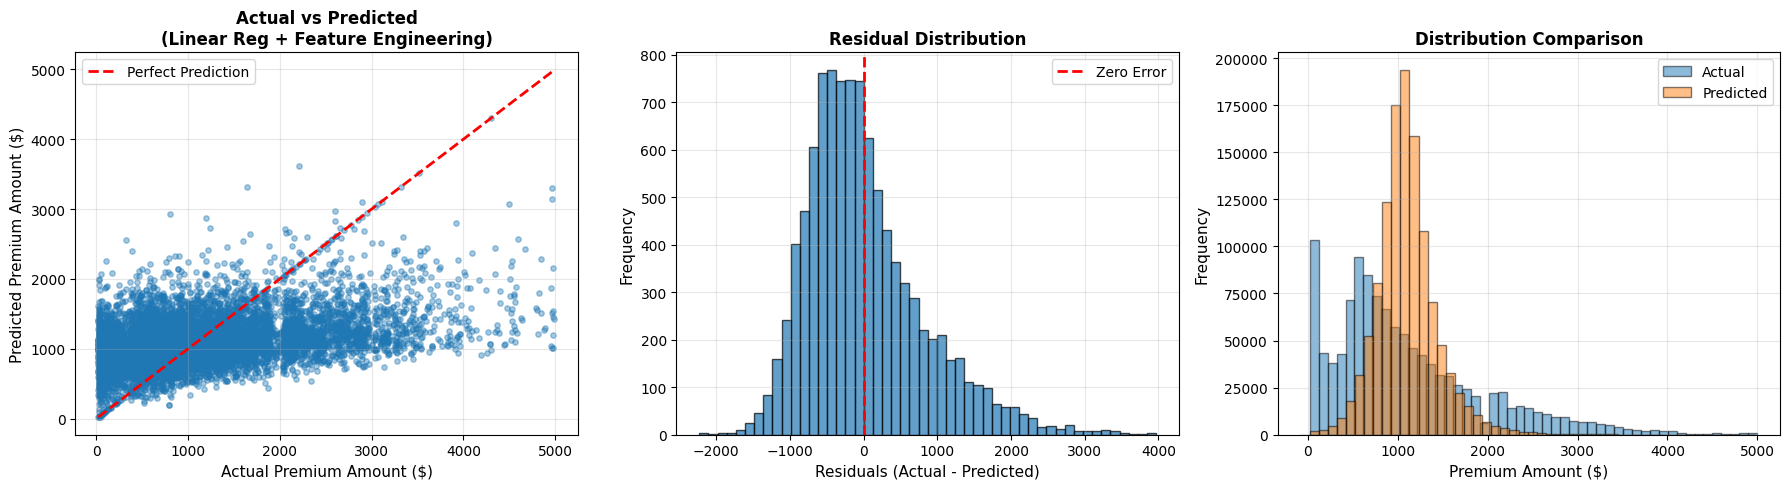

In [36]:
# Sample data for visualization
sample_size = min(10000, len(y_train_arr))
sample_idx = np.random.choice(len(y_train_arr), sample_size, replace=False)
y_train_sample = y_train_arr[sample_idx]
y_pred_sample = y_train_pred[sample_idx]

# Create visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Actual vs Predicted
axes[0].scatter(y_train_sample, y_pred_sample, alpha=0.4, s=15)
axes[0].plot([y_train_arr.min(), y_train_arr.max()], [y_train_arr.min(), y_train_arr.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Premium Amount ($)', fontsize=11)
axes[0].set_ylabel('Predicted Premium Amount ($)', fontsize=11)
axes[0].set_title(f'Actual vs Predicted\n(Linear Reg + Feature Engineering)', 
                  fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Residuals
residuals = y_train_sample - y_pred_sample
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[1].set_xlabel('Residuals (Actual - Predicted)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Residual Distribution', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Distribution comparison
axes[2].hist(y_train_arr, bins=50, alpha=0.5, label='Actual', edgecolor='black')
axes[2].hist(y_train_pred, bins=50, alpha=0.5, label='Predicted', edgecolor='black')
axes[2].set_xlabel('Premium Amount ($)', fontsize=11)
axes[2].set_ylabel('Frequency', fontsize=11)
axes[2].set_title('Distribution Comparison', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Generate Test Predictions

In [37]:
print("Generating predictions on test set...")
y_test_pred = pipeline.predict(X_test)

print(f"✓ Generated {len(y_test_pred):,} predictions")
print(f"\nPrediction statistics:")
print(f"  Min:    ${y_test_pred.min():,.2f}")
print(f"  Max:    ${y_test_pred.max():,.2f}")
print(f"  Mean:   ${y_test_pred.mean():,.2f}")
print(f"  Median: ${np.median(y_test_pred):,.2f}")
print(f"  Std:    ${y_test_pred.std():,.2f}")

Generating predictions on test set...
✓ Generated 800,000 predictions

Prediction statistics:
  Min:    $-253.35
  Max:    $5,086.21
  Mean:   $1,102.32
  Median: $1,074.60
  Std:    $369.58


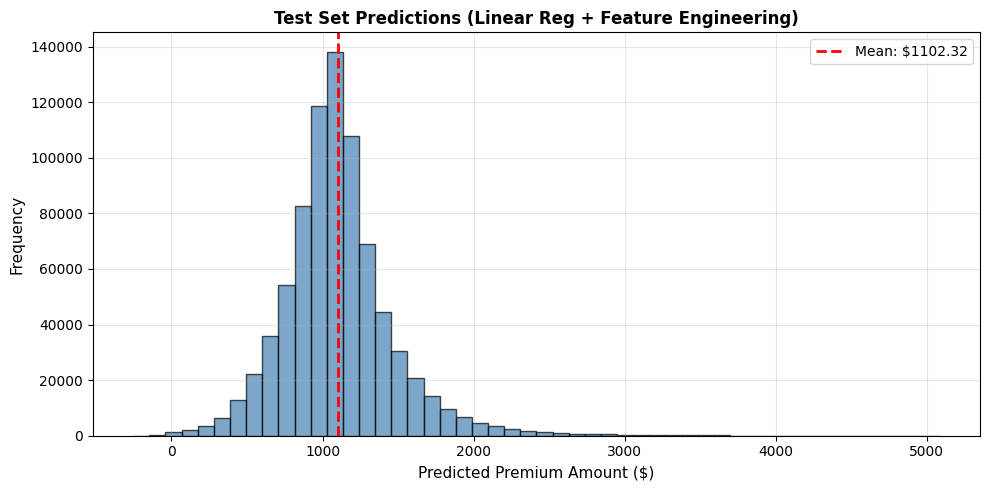

In [38]:
# Visualize test predictions
plt.figure(figsize=(10, 5))
plt.hist(y_test_pred, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Predicted Premium Amount ($)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Test Set Predictions (Linear Reg + Feature Engineering)', fontsize=12, fontweight='bold')
plt.axvline(y_test_pred.mean(), color='r', linestyle='--', linewidth=2, 
            label=f'Mean: ${y_test_pred.mean():.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Save Predictions

In [39]:
# Create submission file
submission = pd.DataFrame({
    'id': X_test['id'] if 'id' in X_test.columns else range(len(X_test)),
    'predicted_premium_amount': y_test_pred
})

# Save to CSV
output_path = "../data/predictions_linear_regression_engineered.csv"
submission.to_csv(output_path, index=False)

print(f"✓ Predictions saved to: {output_path}")
print(f"  Shape: {submission.shape}")
print("\nFirst 10 predictions:")
display(submission.head(10))

✓ Predictions saved to: ../data/predictions_linear_regression_engineered.csv
  Shape: (800000, 2)

First 10 predictions:


,id,predicted_premium_amount
0,1200000,1359.099106
1,1200001,835.625045
2,1200002,1009.599949
3,1200003,1081.800396
4,1200004,1285.475556
5,1200005,661.164085
6,1200006,1292.476172
7,1200007,918.928907
8,1200008,942.654495
9,1200009,1119.863992


## 10. Key Findings & Conclusions

### Summary of Your Feature Engineering:

**Data Cleaning Steps:**
1.  Removed invalid values from Age, Vehicle Age, Insurance Duration
2.  Dropped rows with missing critical fields
3.  Filled Number of Dependents & Previous Claims with 0 (logical)
4.  Filled categorical missing values with 'Unknown'
5.  Filled numeric missing values with median (robust to outliers)

### Why Linear Regression Still Struggles (Even with Clean Data):

1. **Non-linear relationships remain:** Insurance premiums don't scale linearly
   - Smoking status doesn't just add/subtract a constant
   - Age × Health Score interactions aren't captured
   
2. **Categorical encoding limitations:**
   - One-hot encoding creates many features
   - Linear combinations of dummies miss complex patterns
   
3. **Domain complexity:**
   - Insurance pricing uses actuarial tables (exponential curves)
   - Risk factors compound multiplicatively, not additively

